## ***IMDB Text and Sequence***

*Loading the libraries*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from keras import preprocessing
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.optimizers import adam
from google.colab import files
import re, os

To Not Display the Warnings

In [ ]:
# To deprecate warnings that are making the output look clumsy

import logging
logging.getLogger('tensorflow').disabled = True

### ***Model 1 - Basic Model (To understand how embedding and cutoff works)***

*We didn't limit the training, validation and test samples here. I ran a basic model with the entire sample strength to know the model's performance.*

In [ ]:
# Considering only top 10,000 Words
max_features = 10000

# Setting a Cut-Off Point for Reviews after 150 Words
maxlen = 150

# Loading the Train and Test Datasets of the IMDB Example
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pre-Processing to Convert the Texts to Numericals
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

*Building the Network*

In [ ]:
# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
model.add(Embedding(10000, 8, input_length=maxlen))

# Flattening the Size 
model.add(Flatten())

# Adding the Classifer on the top - As the final layer
model.add(Dense(1, activation = 'sigmoid'))

# Compiling the Model
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

*Summary of the Model*

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 8)            80000     
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


*Model Execution*

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_1 = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 37s 57ms/step - loss: 0.5919 - acc: 0.7059 - val_loss: 0.4172 - val_acc: 0.8318
Epoch 2/30
625/625 [==============================] - 7s 11ms/step - loss: 0.3307 - acc: 0.8666 - val_loss: 0.3225 - val_acc: 0.8632
Epoch 3/30
625/625 [==============================] - 5s 7ms/step - loss: 0.2580 - acc: 0.8959 - val_loss: 0.3054 - val_acc: 0.8696
Epoch 4/30
625/625 [==============================] - 4s 6ms/step - loss: 0.2235 - acc: 0.9123 - val_loss: 0.3049 - val_acc: 0.8704
Epoch 5/30
625/625 [==============================] - 5s 7ms/step - loss: 0.1988 - acc: 0.9237 - val_loss: 0.3105 - val_acc: 0.8708
Epoch 6/30
625/625 [==============================] - 3s 6ms/step - loss: 0.1779 - acc: 0.9336 - val_loss: 0.3114 - val_acc: 0.8710
Epoch 7/30
625/625 [==============================] - 3s 4ms/step - loss: 0.1593 - acc: 0.9420 - val_loss: 0.3174 - val_acc: 0.8694
Epoch 8/30
625/625 [==============================] - 3s 5ms/step - loss:

*Visualizing Training and Validation Loss and Accuracy*

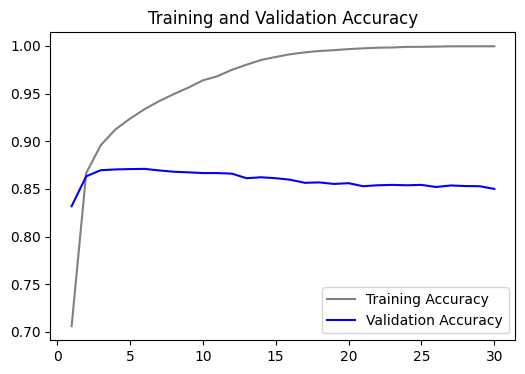

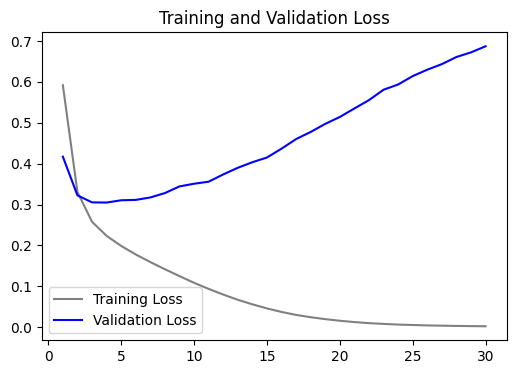

In [ ]:
accuracy = Model_1.history['acc']
val_accuracy = Model_1.history['val_acc']

loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = load_model('model1.keras')
Model1_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

782/782 [==============================] - 2s 2ms/step - loss: 0.3009 - acc: 0.8716
Loss: 0.301
Accuracy: 0.872


Without limiting the training, validaiton and test samples with a embedding layer the model resulted in 87.16% Accuracy.

Now let's start limiting the samples and build the models so as to know the importance of training samples towards the model performance.

### ***Model 2 Training Sample - 100, Validation Sample - 10000, Test Sample - 5000***

*Creating Custom Samples of Train, Validation and Test Set*

In [ ]:
# Setting the maximum number of words to be used in the vocabulary
num_words = 10000

# Loading the IMDB Dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Cut-Off the reviews after 150 words
maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=100, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

*We could verify the custom splits provided by looking at the below code where we are looking at the train, validation and test data.*

In [ ]:
train_texts.shape

(100, 150)

In [ ]:
val_texts.shape

(10000, 150)

In [ ]:
test_texts.shape

(5000, 150)

*Building the Network*

We didn't change the network here, we wanted to use just the embedding layer to assess the model performance.

In [ ]:
# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
model.add(Embedding(10000, 8, input_length=maxlen))

# Flattening the Size 
model.add(Flatten())

# Adding the Classifer on the top - As the final layer
model.add(Dense(1, activation = 'sigmoid'))

# Compiling the Model
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

*Summary of the Model*

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 8)            80000     
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


*Model Execution*

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model2.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_2 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels), 
                    callbacks=callbacks)

Epoch 1/30
4/4 [==============================] - 6s 379ms/step - loss: 0.6966 - acc: 0.4000 - val_loss: 0.6926 - val_acc: 0.5151
Epoch 2/30
4/4 [==============================] - 1s 366ms/step - loss: 0.6746 - acc: 0.8200 - val_loss: 0.6926 - val_acc: 0.5139
Epoch 3/30
4/4 [==============================] - 1s 330ms/step - loss: 0.6595 - acc: 0.9200 - val_loss: 0.6925 - val_acc: 0.5139
Epoch 4/30
4/4 [==============================] - 1s 372ms/step - loss: 0.6459 - acc: 0.9500 - val_loss: 0.6925 - val_acc: 0.5160
Epoch 5/30
4/4 [==============================] - 1s 328ms/step - loss: 0.6330 - acc: 0.9600 - val_loss: 0.6923 - val_acc: 0.5146
Epoch 6/30
4/4 [==============================] - 1s 314ms/step - loss: 0.6205 - acc: 0.9600 - val_loss: 0.6922 - val_acc: 0.5133
Epoch 7/30
4/4 [==============================] - 1s 363ms/step - loss: 0.6075 - acc: 0.9600 - val_loss: 0.6922 - val_acc: 0.5134
Epoch 8/30
4/4 [==============================] - 1s 343ms/step - loss: 0.5941 - acc: 0.96

*Visualizing Training and Validation Loss/Accuracy*

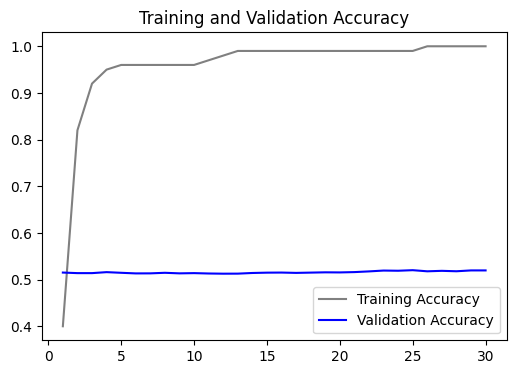

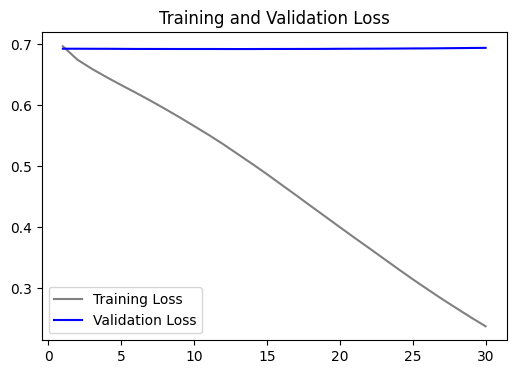

In [ ]:
accuracy = Model_2.history['acc']
val_accuracy = Model_2.history['val_acc']

loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

*Evaluating the Model on Test Set*

In [ ]:
test_model = load_model('model2.keras')
Model2_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model2_Results[0]:.3f}')
print(f'Accuracy: {Model2_Results[1]:.3f}')

157/157 [==============================] - 1s 3ms/step - loss: 0.6925 - acc: 0.5166
Loss: 0.693
Accuracy: 0.517


The model with 100 training samples which was built with just an embedding layer resulted in 51.7% Accuracy, which is not that bad because the model was just trained with 100 Samples.

### ***Model 3 Using Conv1d and Embedding Layer Together***

*Training - 1000, Validation - 10000 and Test - 5000*

In [ ]:
# Setting the maximum number of words to be used in the vocabulary
num_words = 10000

# Loading the IMDB Dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Cut-Off the reviews after 150 words
maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=1000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

17464789/17464789 [==============================] - 2s 0us/step


*Confirming the sizes of the train, validate and test datasets*

In [ ]:
train_texts.shape

(1000, 150)

In [ ]:
val_texts.shape

(10000, 150)

In [ ]:
test_texts.shape

(5000, 150)

*Building the Network - Conv1D along with the Embedding*

In [ ]:
# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
maxlen = 150
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPooling1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

*Summary of the Model*

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 8)            80000     
                                                                 
 conv1d (Conv1D)             (None, 148, 512)          12800     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 256)           393472    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 256)           1

*Running the Model*

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model3.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_3 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels), 
                    callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 20s 285ms/step - loss: 0.6945 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5289
Epoch 2/30
32/32 [==============================] - 7s 220ms/step - loss: 0.6933 - accuracy: 0.5120 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 3/30
32/32 [==============================] - 6s 202ms/step - loss: 0.6928 - accuracy: 0.5120 - val_loss: 0.6930 - val_accuracy: 0.5123
Epoch 4/30
32/32 [==============================] - 5s 177ms/step - loss: 0.6927 - accuracy: 0.5140 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/30
32/32 [==============================] - 7s 224ms/step - loss: 0.6922 - accuracy: 0.5240 - val_loss: 0.6929 - val_accuracy: 0.5202
Epoch 6/30
32/32 [==============================] - 5s 146ms/step - loss: 0.6918 - accuracy: 0.5210 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 7/30
32/32 [==============================] - 3s 94ms/step - loss: 0.6926 - accuracy: 0.4960 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 

*Visualizing the Training and Validation Loss/Accuracy*

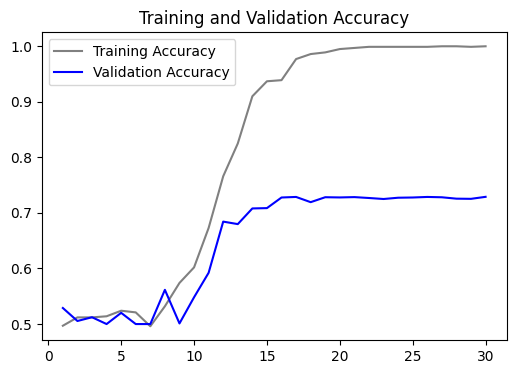

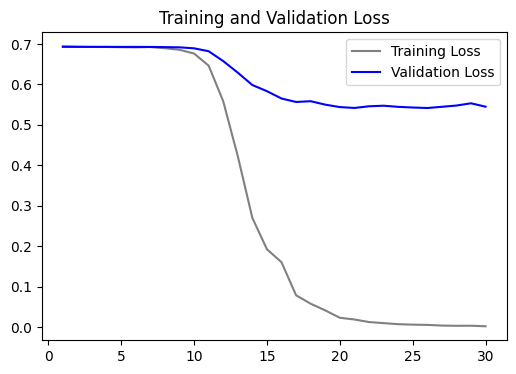

In [ ]:
accuracy = Model_3.history['accuracy']
val_accuracy = Model_3.history['val_accuracy']

loss = Model_3.history["loss"]
val_loss = Model_3.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

*Model Evaluation*

In [ ]:
test_model = load_model('model3.keras')
Model3_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model3_Results[0]:.3f}')
print(f'Accuracy: {Model3_Results[1]:.3f}')

157/157 [==============================] - 1s 5ms/step - loss: 0.5236 - accuracy: 0.7436
Loss: 0.524
Accuracy: 0.744


This is interesting to observe as soon as we increase the training sample size to 1000 and by building a complex network i.e. using Conv1D along with Embedding actually resulted in 74.4% Accuracy.

### ***Model 4 Conv1D and Embedding Layer Together With Change in Network***

*Training - 25000, Validation - 10000 and Test - 5000*

In [ ]:
# Setting the maximum number of words to be used in the vocabulary
num_words = 10000

# Loading the IMDB Dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Cut-Off the reviews after 150 words
maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=25000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

*Verifying the size of the training, validation and test datsets*

In [ ]:
train_texts.shape

(25000, 150)

In [ ]:
val_texts.shape

(10000, 150)

In [ ]:
test_texts.shape

(5000, 150)

*Building the Network*

*We are adding a additional layer to both the Conv1d as well as the Dense network at the end, we also changed the embedding vector dimension to 12 and added dropout layers to all the input layers so as to avoid overfitting*

In [ ]:
# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
maxlen = 150
model.add(Embedding(10000, 12, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(128, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(GlobalMaxPooling1D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0002)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

*Summary of the Model*

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 12)           120000    
                                                                 
 conv1d_11 (Conv1D)          (None, 148, 512)          18944     
                                                                 
 dropout_9 (Dropout)         (None, 148, 512)          0         
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 74, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 72, 256)           393472    
                                                                 
 dropout_10 (Dropout)        (None, 72, 256)           0         
                                                      

*Running the Model*

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_4 = model.fit(train_texts, train_labels,
                    epochs=50,
                    batch_size=64,
                    validation_data=(val_texts, val_labels), 
                    callbacks=callbacks)

Epoch 1/50
391/391 [==============================] - 54s 128ms/step - loss: 0.6935 - accuracy: 0.5046 - val_loss: 0.6930 - val_accuracy: 0.5175
Epoch 2/50
391/391 [==============================] - 15s 38ms/step - loss: 0.6119 - accuracy: 0.6204 - val_loss: 0.5585 - val_accuracy: 0.7876
Epoch 3/50
391/391 [==============================] - 13s 33ms/step - loss: 0.3548 - accuracy: 0.8487 - val_loss: 0.4926 - val_accuracy: 0.8456
Epoch 4/50
391/391 [==============================] - 10s 25ms/step - loss: 0.2808 - accuracy: 0.8878 - val_loss: 0.4517 - val_accuracy: 0.8455
Epoch 5/50
391/391 [==============================] - 8s 22ms/step - loss: 0.2400 - accuracy: 0.9035 - val_loss: 0.4427 - val_accuracy: 0.8443
Epoch 6/50
391/391 [==============================] - 9s 24ms/step - loss: 0.2126 - accuracy: 0.9191 - val_loss: 0.4206 - val_accuracy: 0.8450
Epoch 7/50
391/391 [==============================] - 8s 19ms/step - loss: 0.1838 - accuracy: 0.9310 - val_loss: 0.4080 - val_accuracy: 0

*Visualizing the Training and Validation Loss/Accuracy*

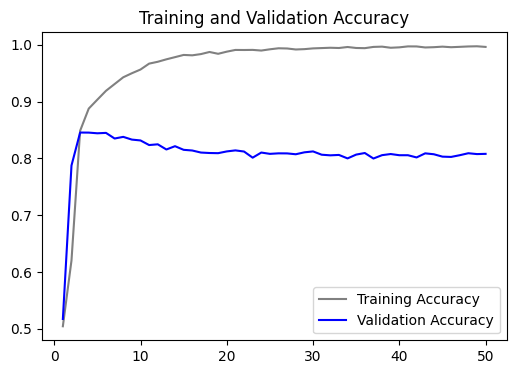

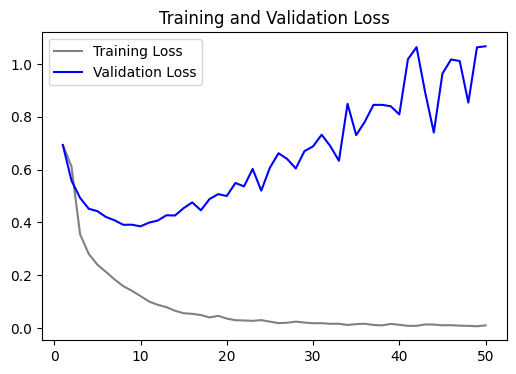

In [ ]:
accuracy = Model_4.history['accuracy']
val_accuracy = Model_4.history['val_accuracy']

loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

*Model Evaluation - Test Set*

In [ ]:
test_model = load_model('model4.keras')
Model4_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model4_Results[0]:.3f}')
print(f'Accuracy: {Model4_Results[1]:.3f}')

157/157 [==============================] - 2s 7ms/step - loss: 0.2899 - accuracy: 0.9080
Loss: 0.290
Accuracy: 0.908


We built a much more complex network i.e. increased the input layers of the Conv1D and also added Dropout for each layer to avoid overfitting, lastly we added 2 dense layers again with dropout and the optimizer being Adam with 0.0002 learning rate, this network along with training samples of 25000 resulted in 90.8% Accuracy.

### ***Model 5 Conv1D and Embedding Layer with Change in Embedding Vector***

*Training - 35000, Validation - 10000 and Test - 5000*

In [ ]:
# Setting the maximum number of words to be used in the vocabulary
num_words = 10000

# Loading the IMDB Dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Cut-Off the reviews after 150 words
maxlen = 150
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=35000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

*Verifying the sizes of training, validation and test datasets*

In [ ]:
train_texts.shape

(35000, 150)

In [ ]:
val_texts.shape

(10000, 150)

In [ ]:
test_texts.shape

(5000, 150)

*Building the Network*

*Everything is same like the previous model, just we changed the embedding vector size to 14 from 12.*

In [ ]:
# Setting the Sequential Layer for Model Building
model = Sequential()

# Adding the Embedding Layer with limiting to consider only the top 10,000 Words
maxlen = 150
model.add(Embedding(10000, 14, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(128, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(GlobalMaxPooling1D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0002)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

*Summary of the Model*

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 14)           140000    
                                                                 
 conv1d_15 (Conv1D)          (None, 148, 512)          22016     
                                                                 
 dropout_15 (Dropout)        (None, 148, 512)          0         
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 74, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 72, 256)           393472    
                                                                 
 dropout_16 (Dropout)        (None, 72, 256)           0         
                                                      

*Running the Model*

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_5 = model.fit(train_texts, train_labels,
                    epochs=50,
                    batch_size=64,
                    validation_data=(val_texts, val_labels), 
                    callbacks=callbacks)

Epoch 1/50
547/547 [==============================] - 67s 117ms/step - loss: 0.6829 - accuracy: 0.5293 - val_loss: 0.6141 - val_accuracy: 0.7312
Epoch 2/50
547/547 [==============================] - 14s 26ms/step - loss: 0.3903 - accuracy: 0.8272 - val_loss: 0.4930 - val_accuracy: 0.8428
Epoch 3/50
547/547 [==============================] - 12s 22ms/step - loss: 0.2991 - accuracy: 0.8768 - val_loss: 0.4477 - val_accuracy: 0.8498
Epoch 4/50
547/547 [==============================] - 12s 22ms/step - loss: 0.2622 - accuracy: 0.8940 - val_loss: 0.4368 - val_accuracy: 0.8509
Epoch 5/50
547/547 [==============================] - 10s 19ms/step - loss: 0.2339 - accuracy: 0.9086 - val_loss: 0.4203 - val_accuracy: 0.8503
Epoch 6/50
547/547 [==============================] - 12s 22ms/step - loss: 0.2122 - accuracy: 0.9175 - val_loss: 0.4045 - val_accuracy: 0.8439
Epoch 7/50
547/547 [==============================] - 10s 18ms/step - loss: 0.1929 - accuracy: 0.9254 - val_loss: 0.3944 - val_accuracy

*Visualizing the Training and Validation Loss/Accuracy*

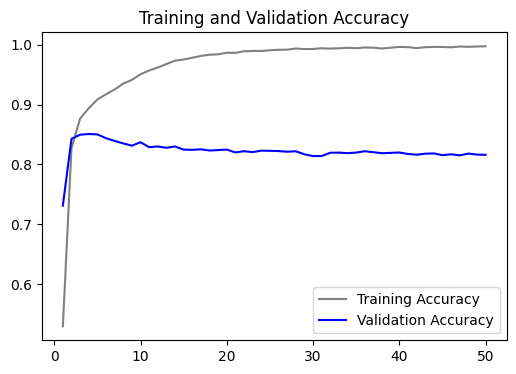

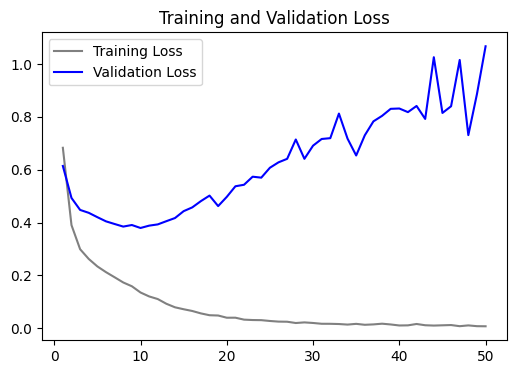

In [ ]:
accuracy = Model_5.history['accuracy']
val_accuracy = Model_5.history['val_accuracy']

loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

*Evaluating the Model on Test Set*

In [ ]:
test_model = load_model('model5.keras')
Model5_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model5_Results[0]:.3f}')
print(f'Accuracy: {Model5_Results[1]:.3f}')

157/157 [==============================] - 1s 4ms/step - loss: 0.2568 - accuracy: 0.9256
Loss: 0.257
Accuracy: 0.926


Just by changing the embedding vector dimension from 12 to 14 and having 10000+ samples for the training when compared to the previous model, model 5 deemed to be the best with highest accuracy of 92.6%.

***We can thus consider the embedding vector dimension as a key hyper parameter to play around with while building the network, but it should be noted that if this parameter is set very high then the model may start to overfit and vice-versa. So, the value thus chosen should be based on the size of the dataset and the end-optimization goal.***

It's not just the embedding vector dimension which is a key hyper parameter we can also fine tune the learning rate, dropout rate, add more or reduce input conv1d layers and dense layers.

We built 4 models in the embedding part i.e. Model 2, Model 3, Model 4 and Model 5. Model 1 was just an base model we aren't considering it for the best model evaluation.

### ***Evaluating the Best Model - Embedding Base Models***

In [ ]:
Models = ['Mod 2', 'Mod 3', 'Mod 4', 'Mod5']
Loss = [0.693,0.524,0.290,0.257]
Accuracy = [0.517,0.744,0.908,0.926]

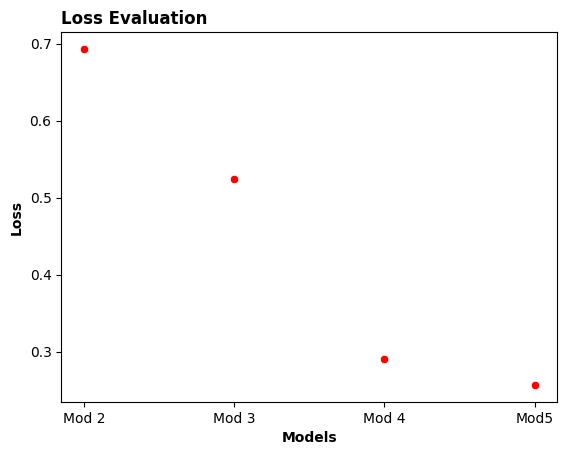

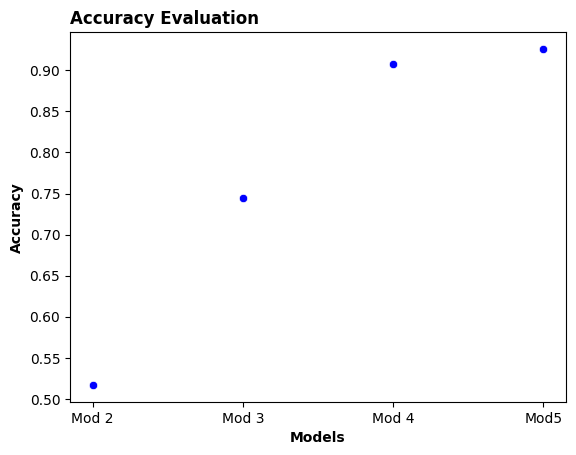

In [ ]:
# Loss Evaluation
sns.scatterplot(x=Models, y=Loss,color='red')
plt.xlabel("Models",fontdict={"size":10,"weight":'bold'})
plt.ylabel("Loss",fontdict={"size":10,"weight":'bold'})
plt.title("Loss Evaluation",loc='left',fontdict={"size":12,"weight":'bold'})
plt.show()

# Accuracy Evaluation
sns.scatterplot(x=Models, y=Accuracy,color='blue')
plt.xlabel("Models",fontdict={"size":10,"weight":'bold'})
plt.ylabel("Accuracy",fontdict={"size":10,"weight":'bold'})
plt.title("Accuracy Evaluation",loc='left',fontdict={"size":12,"weight":'bold'})
plt.show()

***We can clearly observe that Model 5 is the best model among the base embedding models with highest accuracy of around 92.6%.***

***This accuracy was obtained when the training sample was set to 35000, validation to 10000 and test to 5000. We used Conv1D and Embedding Layer together, the network architecture can be referred by looking at the model summary.***

## ***Pre-Trained Models***

### ***Pretrained Word Embedding Model GloVe***

### ***PreTrained Model 1 with Training Samples of 1000***

Loading in the IMDB .tar file to the colab environment

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  48.9M      0  0:00:01  0:00:01 --:--:-- 48.9M


In [ ]:
!rm -r aclImdb/train/unsup

Creating Directories and Appending the data further from Neg and Pos Class of the Data

In [ ]:
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Looking at the total samples in the train class

In [ ]:
print('No. of Samples', len(texts))

No. of Samples 25000


Getting the data ready for modelling and creating train and validation sets

In [ ]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 100  # training on 100 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


Verifying the size of the train and validation samples

In [ ]:
x_train.shape

(100, 150)

In [ ]:
x_val.shape

(10000, 150)

Mounting google drive so as to acess the glove.txt file

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading the pre-trained word embedding file

In [ ]:
glove_dir = '/content/gdrive/My Drive/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Creating a embedding matrix

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

*Building the Network*

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

*Summary of the Model*

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


*Running the Model*

In [ ]:
# Setting Callbacks
callbacks=callbacks = ModelCheckpoint(
            filepath= "premodel1.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_1 =  model.fit(x_train, y_train, 
                     epochs=30, 
                     batch_size=32, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)

Epoch 1/30
4/4 [==============================] - 14s 4s/step - loss: 0.7047 - accuracy: 0.4800 - val_loss: 0.7054 - val_accuracy: 0.5074
Epoch 2/30
4/4 [==============================] - 5s 2s/step - loss: 0.7000 - accuracy: 0.4900 - val_loss: 0.7037 - val_accuracy: 0.5083
Epoch 3/30
4/4 [==============================] - 7s 2s/step - loss: 0.6971 - accuracy: 0.5100 - val_loss: 0.7023 - val_accuracy: 0.5084
Epoch 4/30
4/4 [==============================] - 11s 3s/step - loss: 0.6944 - accuracy: 0.5100 - val_loss: 0.7009 - val_accuracy: 0.5077
Epoch 5/30
4/4 [==============================] - 11s 3s/step - loss: 0.6921 - accuracy: 0.5000 - val_loss: 0.6997 - val_accuracy: 0.5089
Epoch 6/30
4/4 [==============================] - 11s 4s/step - loss: 0.6897 - accuracy: 0.4900 - val_loss: 0.6982 - val_accuracy: 0.5077
Epoch 7/30
4/4 [==============================] - 11s 3s/step - loss: 0.6868 - accuracy: 0.5000 - val_loss: 0.6971 - val_accuracy: 0.5098
Epoch 8/30
4/4 [====================

Visualizing the Training and Validation Loss/Accuracy

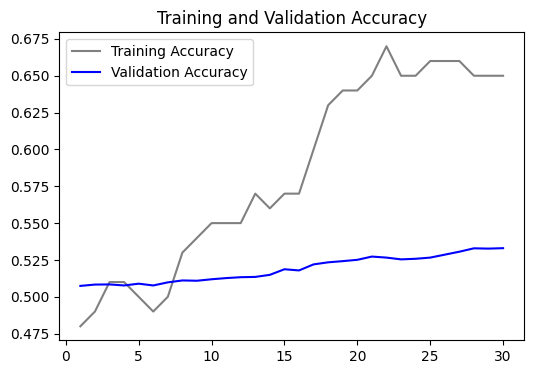

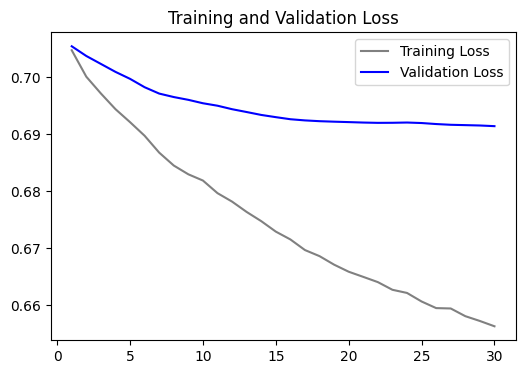

In [ ]:
accuracy = Pre_Model_1.history['accuracy']
val_accuracy = Pre_Model_1.history['val_accuracy']

loss = Pre_Model_1.history["loss"]
val_loss = Pre_Model_1.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Loading the test data for model evaluation

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)[:5000]
y_test = np.asarray(labels)[:5000]

Verifying the shape of the test data

In [ ]:
x_test.shape

(5000, 150)

Model Evaluation

In [ ]:
test_model = load_model('premodel1.keras')
PreModel1_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel1_Results[0]:.3f}')
print(f'Accuracy: {PreModel1_Results[1]:.3f}')

157/157 [==============================] - 4s 25ms/step - loss: 0.6986 - accuracy: 0.4516
Loss: 0.699
Accuracy: 0.452


With 100 Training Samples the model thus built using the weights of the pre-trained model resulted in poor accuracy i.e. of 45.2%.

### ***PreTrained Model 2 with Training Samples of 1000***

In [ ]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 1000  # training on 1000 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


Verifying the size of the train and validation samples

In [ ]:
x_train.shape

(1000, 150)

In [ ]:
x_val.shape

(10000, 150)

Building the Network

Compared to the previous model the network architecture thus built is very strong by having more input layers and dropout and dense layers

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Summary of the Model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_4 (LSTM)               (None, 150, 512)          1255424   
                                                                 
 dropout_5 (Dropout)         (None, 150, 512)          0         
                                                                 
 lstm_5 (LSTM)               (None, 150, 256)          787456    
                                                                 
 dropout_6 (Dropout)         (None, 150, 256)          0         
                                                                 
 lstm_6 (LSTM)               (None, 150, 128)          197120    
                                                                 
 dropout_7 (Dropout)         (None, 150, 128)         

Running the Model

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "premodel2.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_2 =  model.fit(x_train, y_train, 
                     epochs=40, 
                     batch_size=32, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)

Epoch 1/40
32/32 [==============================] - 23s 286ms/step - loss: 0.6908 - accuracy: 0.5290 - val_loss: 0.6925 - val_accuracy: 0.5069
Epoch 2/40
32/32 [==============================] - 7s 217ms/step - loss: 0.6979 - accuracy: 0.4870 - val_loss: 0.6910 - val_accuracy: 0.5687
Epoch 3/40
32/32 [==============================] - 12s 374ms/step - loss: 0.6967 - accuracy: 0.4970 - val_loss: 0.6897 - val_accuracy: 0.5484
Epoch 4/40
32/32 [==============================] - 12s 379ms/step - loss: 0.6881 - accuracy: 0.5360 - val_loss: 0.6781 - val_accuracy: 0.6149
Epoch 5/40
32/32 [==============================] - 7s 221ms/step - loss: 0.6856 - accuracy: 0.5760 - val_loss: 0.6957 - val_accuracy: 0.4942
Epoch 6/40
32/32 [==============================] - 7s 220ms/step - loss: 0.6983 - accuracy: 0.5050 - val_loss: 0.6867 - val_accuracy: 0.5646
Epoch 7/40
32/32 [==============================] - 12s 376ms/step - loss: 0.6773 - accuracy: 0.5720 - val_loss: 0.6613 - val_accuracy: 0.6027
Ep

Visualizing Training and Validation Loss/Accuracy

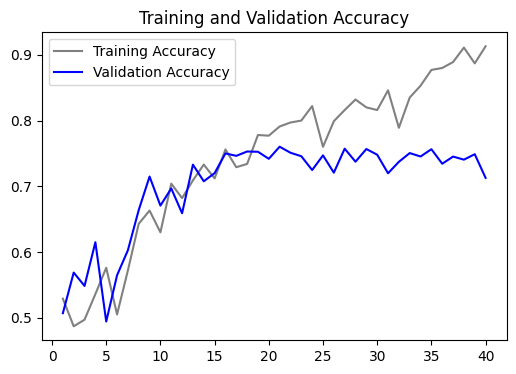

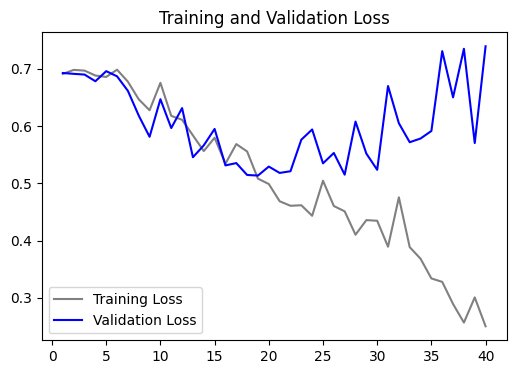

In [ ]:
accuracy = Pre_Model_2.history['accuracy']
val_accuracy = Pre_Model_2.history['val_accuracy']

loss = Pre_Model_2.history["loss"]
val_loss = Pre_Model_2.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Loading the Test Dataset

Limiting the size of the test samples to 5000

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)[:5000]
y_test = np.asarray(labels)[:5000]

Model Evaluation

In [ ]:
test_model = load_model('premodel2.keras')
PreModel2_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel2_Results[0]:.3f}')
print(f'Accuracy: {PreModel2_Results[1]:.3f}')

157/157 [==============================] - 4s 20ms/step - loss: 0.4401 - accuracy: 0.7978
Loss: 0.440
Accuracy: 0.798


The accuracy thus achieved with 1000 training samples and a complex network architecture than the prior model led to a spike in accuracy to 79.8% which is almost equal to 80%.

### ***PreTrained Model 3 with 10000 Training Samples***

In [ ]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 10000  # training on 10000 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 87393 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


Verifying the size of train and validation samples

In [ ]:
x_train.shape

(10000, 150)

In [ ]:
x_val.shape

(10000, 150)

Building the Network

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Looking at the Model Sumamry

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_19 (LSTM)              (None, 150, 64)           42240     
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dense_15 (Dense)            (None, 64)                2112      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,056,833
Trainable params: 56,833
Non-t

Running the Model

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "premodel3.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_3 =  model.fit(x_train, y_train, 
                     epochs=40, 
                     batch_size=64, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)

Epoch 1/40
157/157 [==============================] - 235s 1s/step - loss: 0.6935 - accuracy: 0.5157 - val_loss: 0.6891 - val_accuracy: 0.5328
Epoch 2/40
157/157 [==============================] - 223s 1s/step - loss: 0.6831 - accuracy: 0.5582 - val_loss: 0.6810 - val_accuracy: 0.5731
Epoch 3/40
157/157 [==============================] - 222s 1s/step - loss: 0.6694 - accuracy: 0.5886 - val_loss: 0.6528 - val_accuracy: 0.6110
Epoch 4/40
157/157 [==============================] - 230s 1s/step - loss: 0.6435 - accuracy: 0.6310 - val_loss: 0.6670 - val_accuracy: 0.5759
Epoch 5/40
157/157 [==============================] - 231s 1s/step - loss: 0.6297 - accuracy: 0.6450 - val_loss: 0.6101 - val_accuracy: 0.6671
Epoch 6/40
157/157 [==============================] - 232s 1s/step - loss: 0.5964 - accuracy: 0.6802 - val_loss: 0.5902 - val_accuracy: 0.6886
Epoch 7/40
157/157 [==============================] - 229s 1s/step - loss: 0.5876 - accuracy: 0.6899 - val_loss: 0.5835 - val_accuracy: 0.6947

Visualizing the Training and Validation Loss/Accuracy

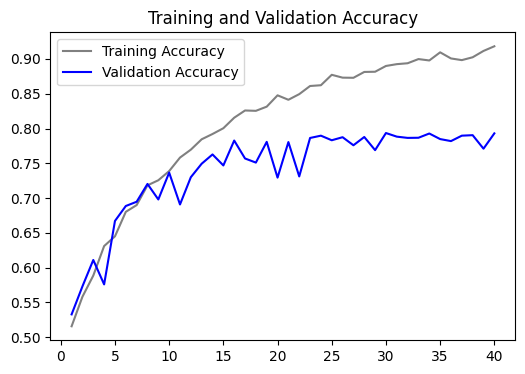

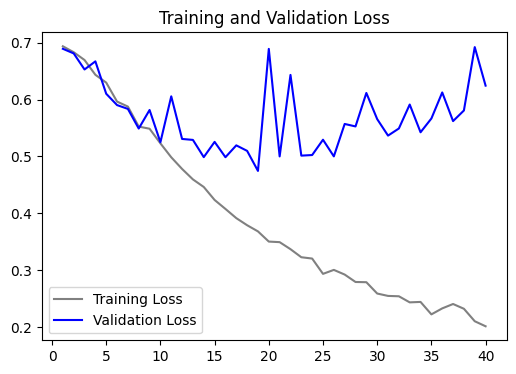

In [ ]:
accuracy = Pre_Model_3.history['accuracy']
val_accuracy = Pre_Model_3.history['val_accuracy']

loss = Pre_Model_3.history["loss"]
val_loss = Pre_Model_3.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Since the test data is already loaded in the previous iteration we aren't loading the test data here, the test data size is 5000 samples, which can be verified in the below cell.

In [ ]:
x_test.shape

(5000, 150)

Evaluating the Model Performance on the Test Set

In [ ]:
test_model = load_model('premodel3.keras')
PreModel3_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel3_Results[0]:.3f}')
print(f'Accuracy: {PreModel3_Results[1]:.3f}')

157/157 [==============================] - 15s 90ms/step - loss: 1.0130 - accuracy: 0.5244
Loss: 1.013
Accuracy: 0.524


Upon continous experiments and changing the network this was the best accuracy thus achieved when the training sample size was set to 10000.

### ***PreModel 4 with Training Samples of 15000***

In [ ]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 15000  # training on 15000 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


Verifying the sample sizes of Training and Validation Set

In [ ]:
x_train.shape

(15000, 150)

In [ ]:
x_val.shape

(10000, 150)

Building the Network

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Looking at the Summary of the Model

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm_21 (LSTM)              (None, 150, 256)          365568    
                                                                 
 dropout_24 (Dropout)        (None, 150, 256)          0         
                                                                 
 lstm_22 (LSTM)              (None, 150, 128)          197120    
                                                                 
 dropout_25 (Dropout)        (None, 150, 128)          0         
                                                                 
 lstm_23 (LSTM)              (None, 128)               131584    
                                                                 
 dense_17 (Dense)            (None, 256)              

Running the Model

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "premodel4.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_4 =  model.fit(x_train, y_train, 
                     epochs=40, 
                     batch_size=64, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)

Epoch 1/40
235/235 [==============================] - 18s 44ms/step - loss: 0.6943 - accuracy: 0.5040 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 2/40
235/235 [==============================] - 9s 38ms/step - loss: 0.6940 - accuracy: 0.4973 - val_loss: 0.6935 - val_accuracy: 0.5029
Epoch 3/40
235/235 [==============================] - 16s 67ms/step - loss: 0.6935 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.5034
Epoch 4/40
235/235 [==============================] - 9s 37ms/step - loss: 0.6934 - accuracy: 0.5046 - val_loss: 0.6932 - val_accuracy: 0.5028
Epoch 5/40
235/235 [==============================] - 9s 40ms/step - loss: 0.6936 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5033
Epoch 6/40
235/235 [==============================] - 9s 40ms/step - loss: 0.6931 - accuracy: 0.5120 - val_loss: 0.6932 - val_accuracy: 0.4985
Epoch 7/40
235/235 [==============================] - 9s 37ms/step - loss: 0.6931 - accuracy: 0.5115 - val_loss: 0.6935 - val_accuracy: 0.50

Visualizing the Training and Validation Loss/Accuracy

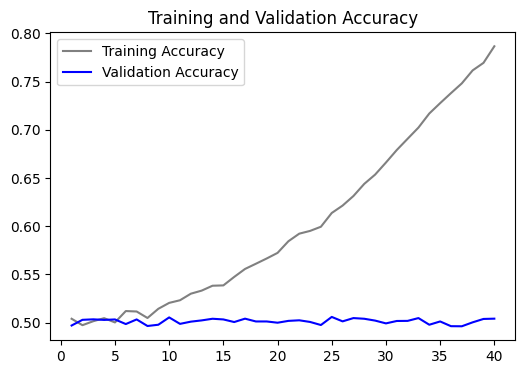

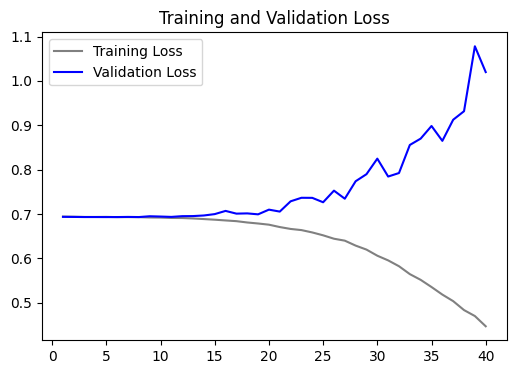

In [ ]:
accuracy = Pre_Model_4.history['accuracy']
val_accuracy = Pre_Model_4.history['val_accuracy']

loss = Pre_Model_4.history["loss"]
val_loss = Pre_Model_4.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the Performance on the Test Set

In [ ]:
test_model = load_model('premodel4.keras')
PreModel4_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel4_Results[0]:.3f}')
print(f'Accuracy: {PreModel4_Results[1]:.3f}')

157/157 [==============================] - 3s 11ms/step - loss: 0.6961 - accuracy: 0.3738
Loss: 0.696
Accuracy: 0.374


From the point where we started increasing the training samples we also started increasing the complexity of the model, which led to poor performance on the test set, so we are trying to reduce the complexity in the next model to see if it generalizes well on the unseen data.

### ***PreModel 5 Reducing the complexity in the model, 15000 Training Samples***

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

model.add(LSTM(128))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compiling the Model
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

Looking at the summary of the model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,150,529
Trainable params: 150,529
Non-tr

Running the model

In [ ]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "premodel5.keras",
            save_best_only= True,
            monitor= "val_loss"
            )

# Model Fit
Pre_Model_5 =  model.fit(x_train, y_train, 
                     epochs=40, 
                     batch_size=64, 
                     validation_data=(x_val, y_val),
                     callbacks=callbacks)

Epoch 1/40
235/235 [==============================] - 100s 400ms/step - loss: 0.6276 - accuracy: 0.6518 - val_loss: 0.5723 - val_accuracy: 0.7106
Epoch 2/40
235/235 [==============================] - 91s 389ms/step - loss: 0.5302 - accuracy: 0.7471 - val_loss: 0.5397 - val_accuracy: 0.7140
Epoch 3/40
235/235 [==============================] - 119s 506ms/step - loss: 0.4621 - accuracy: 0.7919 - val_loss: 0.4353 - val_accuracy: 0.8042
Epoch 4/40
235/235 [==============================] - 132s 564ms/step - loss: 0.4183 - accuracy: 0.8090 - val_loss: 0.4062 - val_accuracy: 0.8198
Epoch 5/40
235/235 [==============================] - 92s 394ms/step - loss: 0.3908 - accuracy: 0.8235 - val_loss: 0.3892 - val_accuracy: 0.8290
Epoch 6/40
235/235 [==============================] - 92s 394ms/step - loss: 0.3665 - accuracy: 0.8397 - val_loss: 0.3609 - val_accuracy: 0.8405
Epoch 7/40
235/235 [==============================] - 93s 398ms/step - loss: 0.3418 - accuracy: 0.8496 - val_loss: 0.3751 - val

Visualizing the Training and Validation Loss/Accuracy

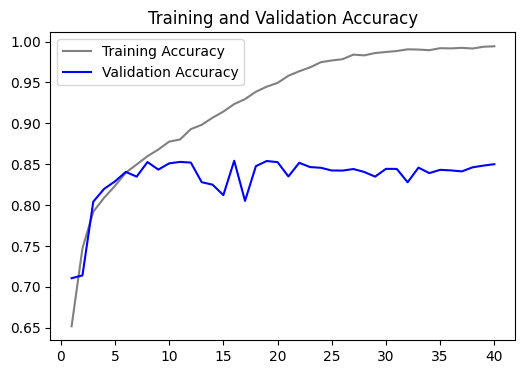

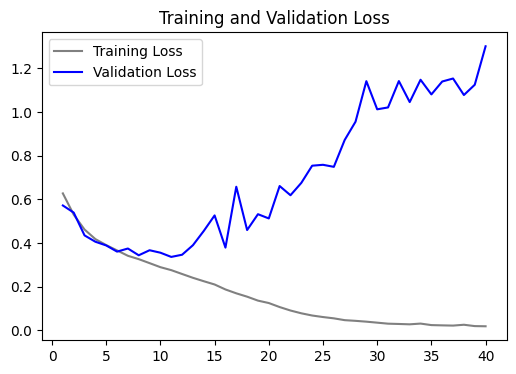

In [ ]:
accuracy = Pre_Model_5.history['accuracy']
val_accuracy = Pre_Model_5.history['val_accuracy']

loss = Pre_Model_5.history["loss"]
val_loss = Pre_Model_5.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Evaluating the performance of the model on test set

In [ ]:
test_model = load_model('premodel5.keras')
PreModel5_Results = test_model.evaluate(x_test,y_test)
print(f'Loss: {PreModel5_Results[0]:.3f}')
print(f'Accuracy: {PreModel5_Results[1]:.3f}')

157/157 [==============================] - 19s 109ms/step - loss: 0.3320 - accuracy: 0.8508
Loss: 0.332
Accuracy: 0.851


This seems to be a good performance than compared to the complex architecture that we built before for the same training sample size. 

The prior model i.e. PreModel 4 was underfitting since the accuracy in the training set is also very less which indicates that the model wasn't able to learn or understand the sentiments of the reviewers, if the model isn't able to train well on the training data it can't do well on the unseen data and as expected the model's performance on the validation set was bad and so was on the test set.

***Let's evaluate the performance of models which has been using pre-trained embedding vectors.***

In [2]:
Models = ['Pre1','Pre2','Pre3','Pre4','Pre5']
Loss = [0.699, 0.440, 1.013,0.696, 0.332]
Accuracy = [0.452, 0.798, 0.524, 0.374,0.851]

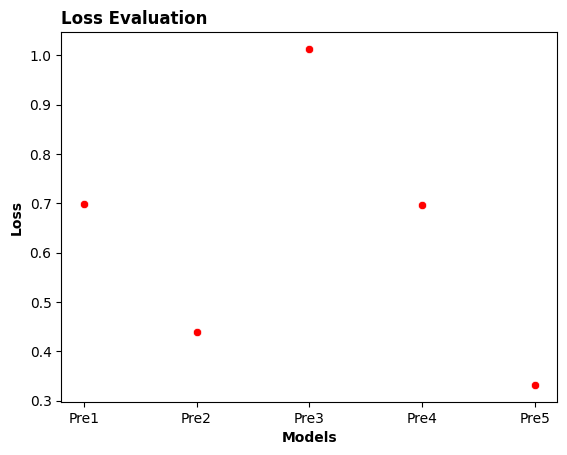

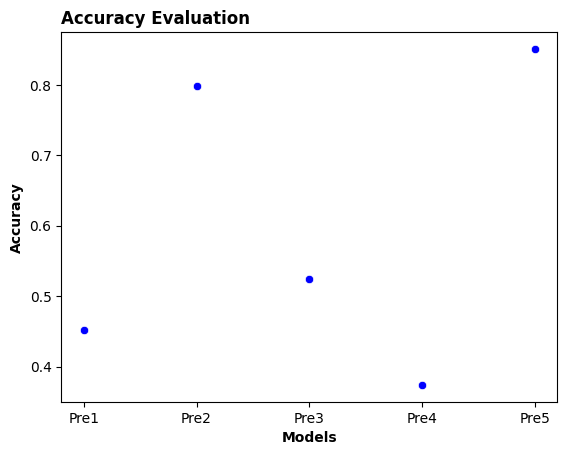

In [5]:
#Loss Evaluation
sns.scatterplot(x=Models, y=Loss, color='red')
plt.xlabel("Models",fontdict={"size":10,"weight":'bold'})
plt.ylabel("Loss",fontdict={"size":10,"weight":'bold'})
plt.title("Loss Evaluation",loc='left',fontdict={"size":12,"weight":'bold'})
plt.show()

# Accuracy Evaluation
sns.scatterplot(x=Models, y=Accuracy,color='blue')
plt.xlabel("Models",fontdict={"size":10,"weight":'bold'})
plt.ylabel("Accuracy",fontdict={"size":10,"weight":'bold'})
plt.title("Accuracy Evaluation",loc='left',fontdict={"size":12,"weight":'bold'})
plt.show()

As we can see from the above plots that PreModel 5 which has been trained on 15000 samples with less complex network has deemed to be best performing when compared to the rest of the models.

At times less complex models i.e. simple models are proved to be the best performers when compared with other models.

If we look at the epoch cycle of all the Pre_Trained Models most of them were underfitting, i.e. the model wasn't able to learn the patterns and understand the sentimnets of the data which it has seen eventually the model's performance on unseen data can be expected to be much worse and so it was. But the final model was able to train well on the data which it has seen and it deemed to be the best model among the Pre_trained models sector.

### ***Overall Evaluation***

In the base models we ran 4 models with varied training sample sizes holding the validation and test constant at 10000 and 5000. All the models performed good i.e. they didn't underfit they tried to learn most of the characteristics of the training samples and finally after a point they started overfitting, but there was a sweet spot which we captured through the callbacks and evaluated the test set based on that.

When the training sample was set to 35000 and by fine tuning the hyper parameters such as learning rate, embedding vector dimension, Conv1D layers, Dense layers, nodes, dropout rate we were able to get the best performance of 92% Accuracy.

***From the base models evaluation I could say that as a modeller it's very important to know which knob needs to be adjusted so as to increase the models performance on the test set and by fine tuning these values based on the models performance we can achieve better generalization.***

***In the pre-trained models evaluation we got to know that complex networks are not always the best choice to improve on model's generalization ability, at times weak learners or simple models can outperform others and it was likely the case in our models performance. Also, we must always keep an eye to know whether the model is underfitting or overfitting and fine tune the parameters based on that.***